# BSUD Project 2

# Import Labraries: 

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from textblob import TextBlob
import os
import nltk
nltk.download()



showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


2024-12-09 14:01:53.614 python[27795:1640546] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-09 14:01:53.614 python[27795:1640546] +[IMKInputSession subclass]: chose IMKInputSession_Modern


True

# Set Up Paths

In [38]:
# Set up paths
data_folder = "../data"
reviews_path = os.path.join(data_folder, "tripadvisor_hotel_reviews.csv")
sentiment_path = os.path.join(data_folder, "tripadvisor_hotel_reviews_sentiment.csv")
target_sentiment_path = os.path.join(data_folder, "tripadvisor_hotel_reviews_target_sentiment.csv")
stopwords_path = os.path.join(data_folder, "Additional_Stopwords.txt")

import os

# Print each file path and check existence
print("Reviews path exists:", os.path.exists(reviews_path))
print("Sentiment path exists:", os.path.exists(sentiment_path))
print("Target sentiment path exists:", os.path.exists(target_sentiment_path))
print("Stopwords path exists:", os.path.exists(stopwords_path))



Reviews path exists: True
Sentiment path exists: True
Target sentiment path exists: True
Stopwords path exists: True


# Load Data

In [44]:
# Load datasets
print(os.path.exists(stopwords_path))  # Should return True if the file exists

import os

# Check current working directory
print(os.getcwd())

# Replace 'absolute_path_to_data_folder' with the full path to your data folder
stopwords_path =os.path.join(data_folder, "Additional_Stopwords.txt")

# Load stopwords
try:
    with open(stopwords_path, "r") as file:
        additional_stopwords = file.read().splitlines()
    print("Stopwords loaded successfully!")
except Exception as e:
    print(f"Error loading stopwords: {e}")



True
/Users/muhi/PycharmProjects/scientificProject/models
Stopwords loaded successfully!


# Preprocessing

In [45]:
# Combine NLTK stopwords with additional stopwords
nltk_stopwords = set(stopwords.words("english"))
combined_stopwords = nltk_stopwords.union(set(additional_stopwords))

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in combined_stopwords]
    return " ".join(tokens)

# Apply preprocessing
reviews["processed_text"] = reviews["Review"].apply(preprocess)
reviews.head()



,Review,Rating,processed_text
0,nice hotel expensive parking got good deal sta...,4,expensive parking deal anniversary arrived lat...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,room 4 4 large mediterranean suite comfortable...
3,"unique, great stay, wonderful time hotel monac...",5,unique wonderful excellent short stroll main d...
4,"great stay great stay, went seahawk game aweso...",5,seahawk game awesome downfall view building co...


# Sentiment Analysis

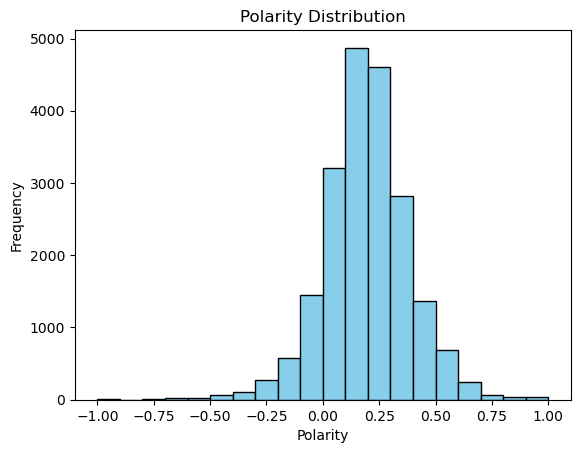

In [46]:
# Sentiment analysis with TextBlob
reviews["polarity"] = reviews["processed_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
reviews["subjectivity"] = reviews["processed_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Visualize sentiment polarity distribution
plt.hist(reviews["polarity"], bins=20, color="skyblue", edgecolor="black")
plt.title("Polarity Distribution")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.show()


# Topic Modelling

In [47]:
# Vectorize text with TF-IDF
# Vectorization and LDA
try:
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(reviews["processed_text"])

    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(tfidf_matrix)

    # Print topics
    for idx, topic in enumerate(lda.components_):
        print(f"Topic {idx+1}:")
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print("Topic modeling complete!")
except Exception as e:
    print(f"Error during topic modeling: {e}")


Topic 1:
['door', 'parking', 'floor', 'stayed', 'place', 'staff', 'day', 'bed', 'service', 'room']
Topic 2:
['apartment', 'cruise', 'view', 'ferry', 'airport', 'shuttle', 'sydney', 'kong', 'hong', 'harbour']
Topic 3:
['comfortable', 'breakfast', 'service', 'wonderful', 'helpful', 'friendly', 'room', 'excellent', 'stayed', 'staff']
Topic 4:
['minute', 'excellent', 'stayed', 'street', 'small', 'station', 'staff', 'room', 'walk', 'breakfast']
Topic 5:
['service', 'drink', 'vacation', 'beautiful', 'restaurant', 'day', 'pool', 'food', 'beach', 'resort']
Topic modeling complete!


# Clustering

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


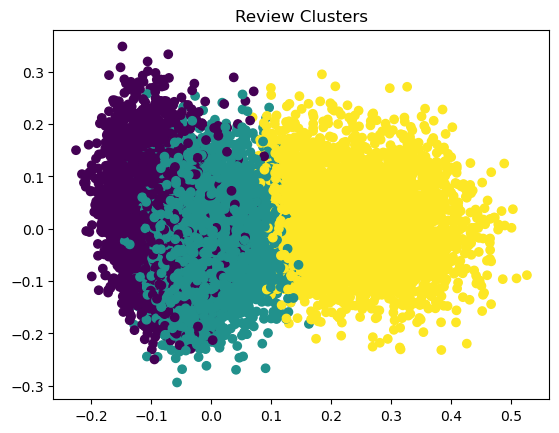

In [48]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
reviews["cluster"] = kmeans.fit_predict(tfidf_matrix)

# Visualize clusters
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=reviews["cluster"], cmap="viridis")
plt.title("Review Clusters")
plt.show()


# Generate Insights

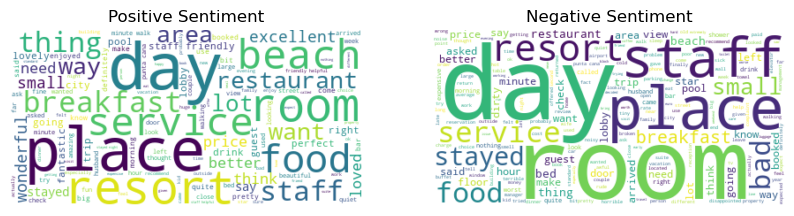

In [49]:
positive_reviews = " ".join(reviews[reviews["polarity"] > 0]["processed_text"])
negative_reviews = " ".join(reviews[reviews["polarity"] < 0]["processed_text"])

# Generate word clouds
positive_wc = WordCloud(background_color="white").generate(positive_reviews)
negative_wc = WordCloud(background_color="white").generate(negative_reviews)

# Display word clouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Sentiment")

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Sentiment")

plt.show()


Save Results

In [50]:
reviews.to_csv(os.path.join(data_folder, "processed_reviews.csv"), index=False)
